In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import numpy as np

# Camvid Segmentation
* load paths and examine file structures and images
* create databunch
* visualize a few batches
* create model
* train model
* evaluate

### Load paths and examine file structures and images

In [3]:
path = untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/home/CW01/uia94835/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/CW01/uia94835/.fastai/data/camvid/images'),
 PosixPath('/home/CW01/uia94835/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/CW01/uia94835/.fastai/data/camvid/labels')]

In [5]:
!cat /home/CW01/uia94835/.fastai/data/camvid/codes.txt | head

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence


In [6]:
!cat /home/CW01/uia94835/.fastai/data/camvid/valid.txt | head

0016E5_07959.png
0016E5_07961.png
0016E5_07963.png
0016E5_07965.png
0016E5_07967.png
0016E5_07969.png
0016E5_07971.png
0016E5_07973.png
0016E5_07975.png
0016E5_07977.png


In [7]:
!ls /home/CW01/uia94835/.fastai/data/camvid/labels | head

0001TP_006690_P.png
0001TP_006720_P.png
0001TP_006750_P.png
0001TP_006780_P.png
0001TP_006810_P.png
0001TP_006840_P.png
0001TP_006870_P.png
0001TP_006900_P.png
0001TP_006930_P.png
0001TP_006960_P.png


In [8]:
!ls /home/CW01/uia94835/.fastai/data/camvid/images | head

0001TP_006690.png
0001TP_006720.png
0001TP_006750.png
0001TP_006780.png
0001TP_006810.png
0001TP_006840.png
0001TP_006870.png
0001TP_006900.png
0001TP_006930.png
0001TP_006960.png


In [9]:
codes = np.loadtxt('/home/CW01/uia94835/.fastai/data/camvid/codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [10]:
image_path = path/'images'
label_path = path/'labels'
image_files = get_image_files(image_path)
label_files = get_image_files(label_path)
valid_file = path/'valid.txt'
print(image_files[0])
print(label_files[0])
#print(label_files.ls()[:5])

/home/CW01/uia94835/.fastai/data/camvid/images/0016E5_00750.png
/home/CW01/uia94835/.fastai/data/camvid/labels/0001TP_009690_P.png


In [11]:
get_y_fn = lambda x: label_path/f'{x.stem}_P{x.suffix}'

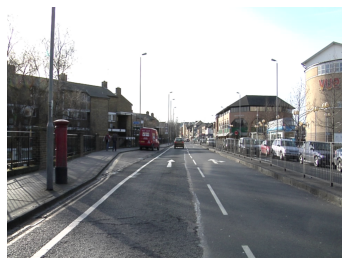

In [13]:
#open_image(image_files[0])
img = open_image(image_files[0])
img.show(figsize=(6,6))

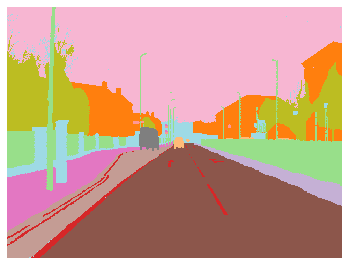

In [53]:
mask = open_mask(get_y_fn(image_files[0]))
mask.show(figsize=(6,6), alpha=1)

### Create databunch

In [61]:
src_size = np.array(mask.shape[1:])
src_size

array([720, 960])

In [63]:
size = src_size//2
size

array([360, 480])

In [85]:
bs=8
src = SegmentationItemList.from_folder(image_path).split_by_fname_file(valid_file).label_from_func(get_y_fn, classes=codes).transform(get_transforms(), tfm_y=True, size=size).databunch(bs=bs).normalize(imagenet_stats)
src

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Test: None

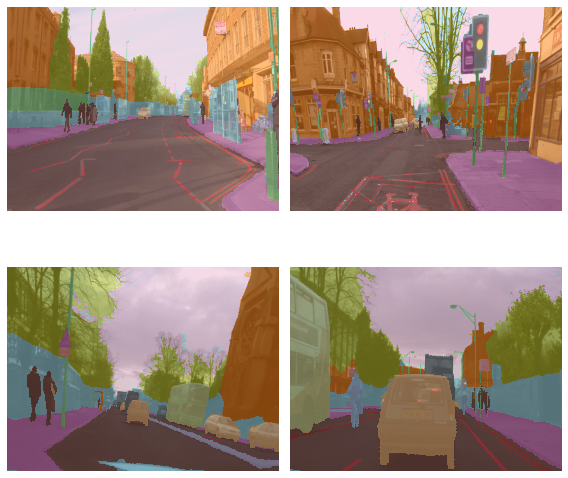

In [65]:
src.show_batch()

### Create model

In [86]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [87]:
learn.destroy()
gc.collect()

this object has been destroyed


268

In [88]:
wd=1e-2
learn = unet_learner(src, models.resnet34, metrics=acc_camvid, wd = wd)

In [89]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


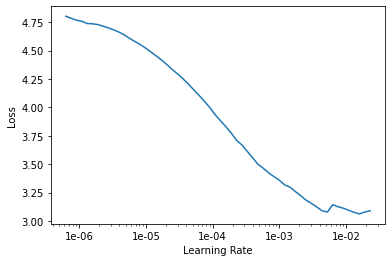

In [90]:
learn.recorder.plot()

In [91]:
learn.fit_one_cycle(10, max_lr = 3e-4)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.910405,0.995630,0.768564,00:47
1,1.066793,0.638037,0.836496,00:45
2,0.778079,0.674194,0.821189,00:45
3,0.624623,0.493678,0.862121,00:45
4,0.536913,0.397146,0.897170,00:45
5,0.474025,0.376618,0.892320,00:45
6,0.425168,0.332213,0.907141,00:45
7,0.399248,0.335116,0.907189,00:45
8,0.370471,0.308386,0.910751,00:45
9,0.351603,0.310148,0.909851,00:45


In [92]:
learn.unfreeze()

In [93]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


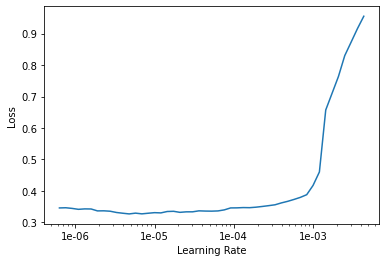

In [94]:
learn.recorder.plot()

In [95]:
learn.fit_one_cycle(12, max_lr = slice(1e-5, (3e-3)/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.362189,0.344448,0.901935,00:47
1,0.413904,0.386778,0.897335,00:47
2,0.453191,0.375667,0.898528,00:47
3,0.442288,0.390439,0.892830,00:47
4,0.398800,0.293444,0.917572,00:47
5,0.385356,0.324618,0.909056,00:47
6,0.343194,0.300962,0.913806,00:47
7,0.304352,0.279415,0.921557,00:47
8,0.278142,0.271071,0.923943,00:47
9,0.256876,0.263361,0.925734,00:47


In [98]:
learn.freeze()

In [99]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


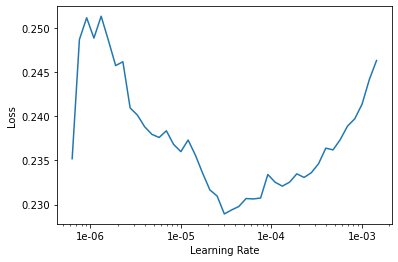

In [100]:
learn.recorder.plot()

In [102]:
learn.fit_one_cycle(1, max_lr=(3e-5)/2, pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.230862,0.267765,0.925800,00:44


In [106]:
learn.fit_one_cycle(1, max_lr=(3e-5)/2, pct_start=0.1)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.225069,0.261118,0.927399,00:45


In [110]:
learn.unfreeze()

In [111]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


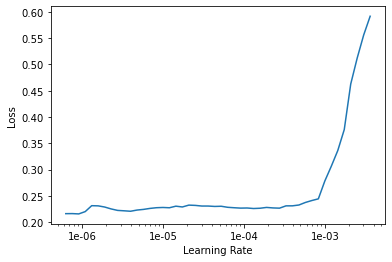

In [112]:
learn.recorder.plot()

In [113]:
learn.fit_one_cycle(1, max_lr=1e-6, pct_start=0.2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.223206,0.263782,0.926831,00:47


In [114]:
learn.fit_one_cycle(1, max_lr=1e-6, pct_start=0.2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.226026,0.263101,0.927124,00:47


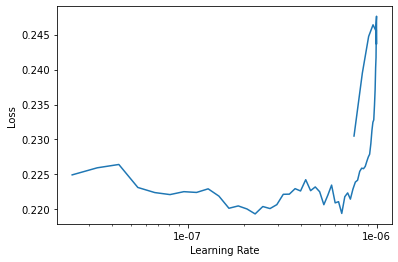

In [115]:
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(1, max_lr=slice((1e-7)/2, (1e-6)/3), pct_start=0.2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.225358,0.260604,0.927568,00:47


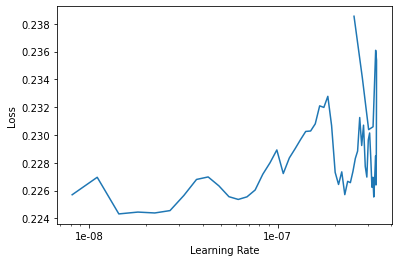

In [117]:
learn.recorder.plot()

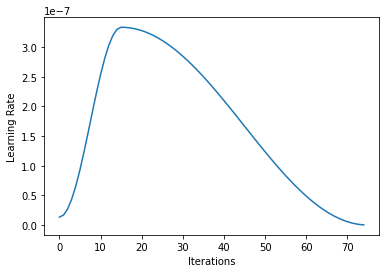

In [118]:
learn.recorder.plot_lr()

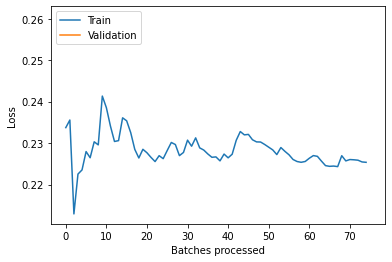

In [119]:
learn.recorder.plot_losses()

In [120]:
learn.save('half-size')

### Full size

In [121]:
bs=2
src = SegmentationItemList.from_folder(image_path).split_by_fname_file(valid_file).label_from_func(get_y_fn, classes=codes).transform(get_transforms(), tfm_y=True).databunch(bs=bs).normalize(imagenet_stats)
src

ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Test: None

In [122]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [123]:
gc.collect()

22

In [125]:
learn = unet_learner(src, models.resnet34, metrics=acc_camvid, wd=wd)

In [126]:
learn.load('half-size')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/CW01/uia94835/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


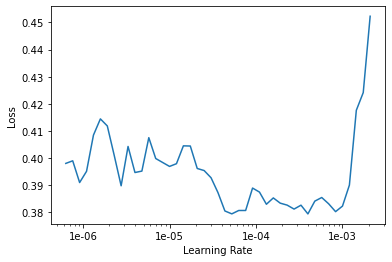

In [127]:
lr_find(learn)
learn.recorder.plot()

In [128]:
lr= 3e-5
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.392813,0.305367,0.918036,03:18
1,0.355129,0.298740,0.918638,03:16
2,0.346164,0.276120,0.923248,03:16
3,0.323068,0.273127,0.923825,03:16
4,0.305330,0.263441,0.926005,03:16
5,0.292274,0.261634,0.927094,03:16
6,0.300355,0.248965,0.930867,03:16
7,0.271247,0.256388,0.928613,03:17
8,0.272233,0.250559,0.929405,03:17
9,0.252561,0.246710,0.930112,03:16


In [129]:
learn.save('stage-1-big')

In [130]:
learn.unfreeze()

In [131]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


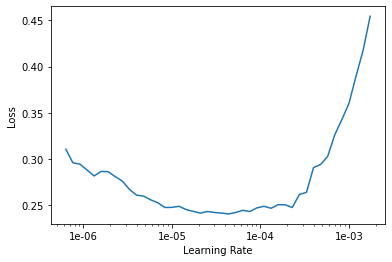

In [132]:
learn.recorder.plot()

In [133]:
lrs = slice(1e-6,lr/10)
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.245070,0.250679,0.929136,03:23
1,0.263886,0.253284,0.927962,03:24
2,0.262689,0.252403,0.928336,03:24
3,0.236063,0.246794,0.929792,03:25
4,0.243607,0.250368,0.929333,03:25
5,0.242412,0.237820,0.932225,03:25
6,0.240165,0.249319,0.929698,03:24
7,0.234466,0.245599,0.929925,03:24
8,0.226836,0.237396,0.932309,03:25
9,0.229968,0.245082,0.929871,03:25


In [134]:
lrs = slice(1e-6,1e-5)
learn.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.823175,0.806509,0.823082,03:22
1,0.656615,0.437416,0.883525,03:21


In [135]:
lrs = slice(1e-6,1e-5)
learn.fit_one_cycle(5, pct_start=0.2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.694967,0.772753,0.817593,03:21
1,0.599019,0.487668,0.870629,03:21
2,0.461009,0.383696,0.892186,03:21
3,0.377720,0.292209,0.910402,03:20
4,0.333226,0.285262,0.915977,03:21
